# ***Import Libraries***

In [44]:
import tensorflow as tf
import keras,os,cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from gtts import gTTS
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# ***Reading Data***

In [24]:
TRAINING_PATH = '/kaggle/input/brain-tumor-mri-dataset/Training'
TESTING_PATH = '/kaggle/input/brain-tumor-mri-dataset/Testing'
SIZE = 224
NUM_CLASSES = 4
RESCALE=1./255
ROTATION_RANGE=20

SHEAR_RANGE=0.2
ZOOM_RANGE=0.05

HORIZONTAL_FLIP=True

FILTER_SIZE=3
MAXPOOLING_SIZE=2

LEARNING_RATE=1e-4

BATCH_SIZE=32
CHANNEL=3

In [3]:
for i in os.listdir(TRAINING_PATH):
    print(i, len(os.listdir(os.path.join(TRAINING_PATH, i))))

pituitary 1457
notumor 1595
meningioma 1339
glioma 1321


In [4]:
for i in os.listdir(TESTING_PATH):
    print(i, len(os.listdir(os.path.join(TESTING_PATH, i))))

pituitary 300
notumor 405
meningioma 306
glioma 300


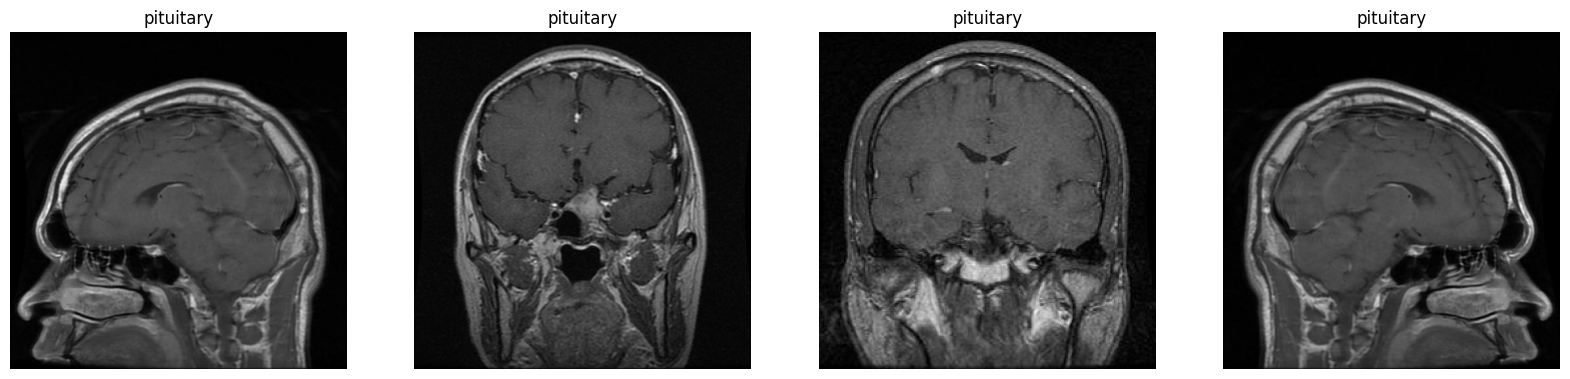

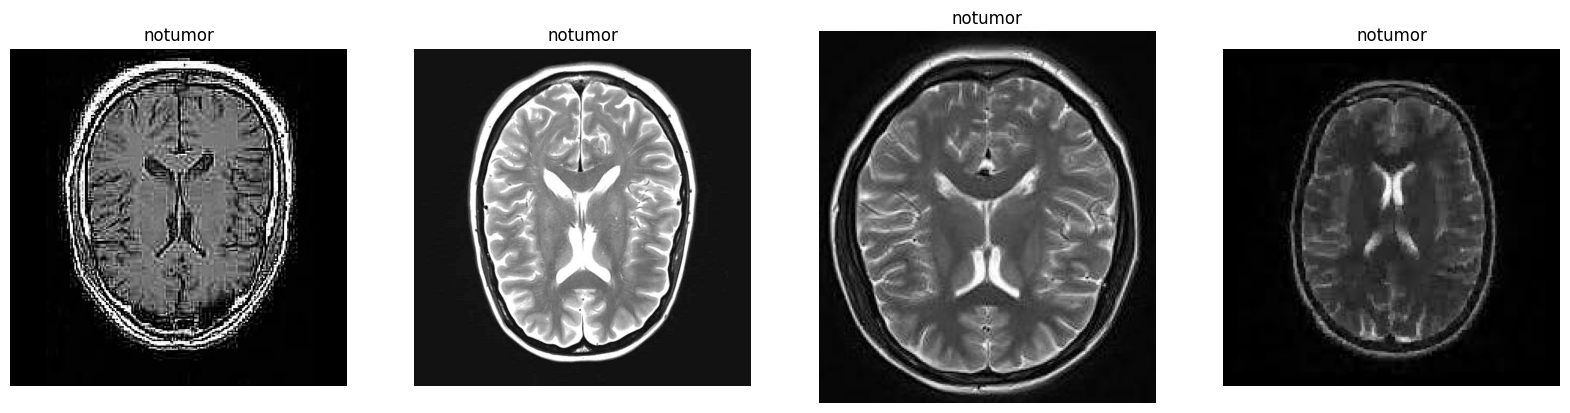

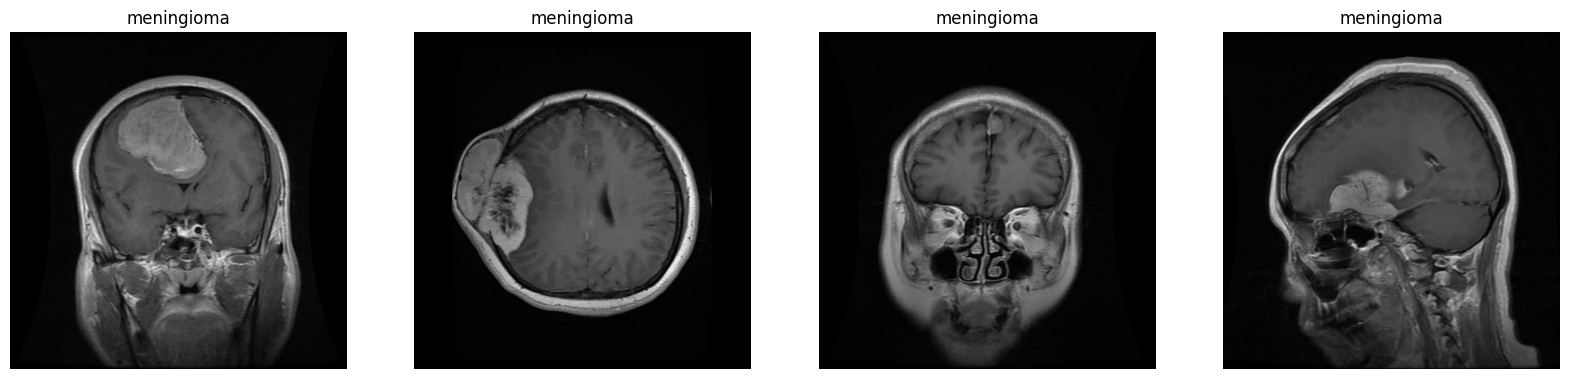

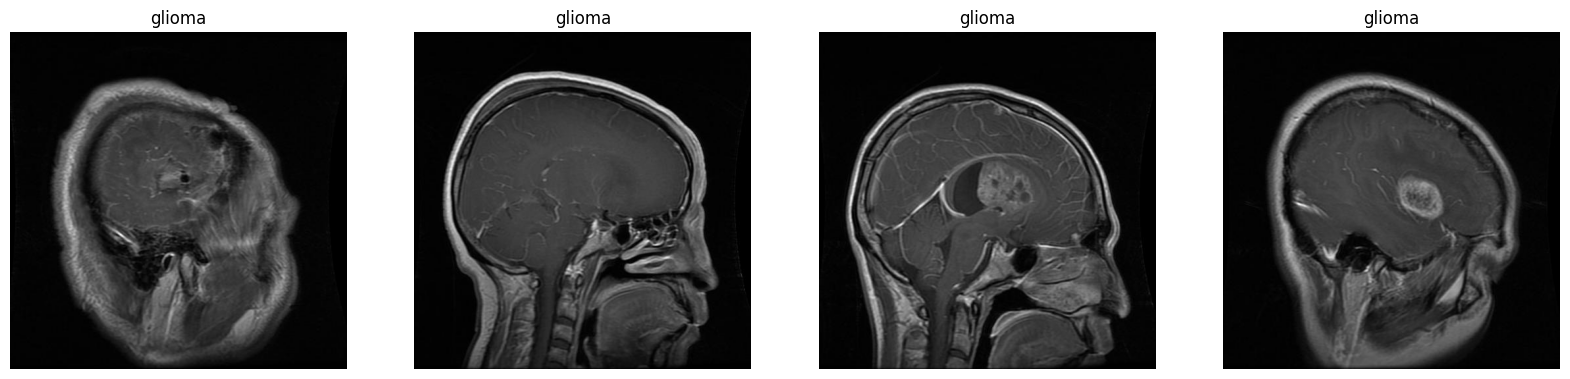

In [5]:
for label in os.listdir(TRAINING_PATH):
    plt.figure(figsize=(20,20))
    count=0
    for i,j in enumerate(os.listdir(os.path.join(TRAINING_PATH, label))):
        plt.subplot(1,4,i+1)
        img = cv2.imread(os.path.join(TRAINING_PATH, label, j))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        count+=1
        if count==4:
            break
plt.show()


# ***Show size of images***

In [6]:
images_size=[]
for label in os.listdir(TRAINING_PATH):
    folder_path=os.path.join(TRAINING_PATH,label)
    for image_name in tqdm(os.listdir(folder_path)):
        img_path=os.path.join(folder_path,image_name)
        img=cv2.imread(img_path)
        shape=img.shape
        images_size.append(shape)

100%|██████████| 1321/1321 [00:06<00:00, 191.87it/s]


In [7]:
print(list(set(images_size))[:10])

[(395, 367, 3), (290, 236, 3), (717, 717, 3), (302, 216, 3), (245, 206, 3), (512, 434, 3), (250, 201, 3), (274, 230, 3), (442, 442, 3), (228, 233, 3)]


here is a difference in the sizes of the images, so must resize the images for CNN to enter

# ***Preprocessing***

In [8]:
def read_resize_data(PATH):
    LABELS=os.listdir(PATH)
    X=[]
    y=[]

    for label in LABELS:

        folder_path=os.path.join(PATH,label)
        for image_name in tqdm(os.listdir(folder_path)):
            img_path=os.path.join(folder_path,image_name)
            img=cv2.imread(img_path)
            img = cv2.resize(img, (SIZE, SIZE))
            X.append(img)
            y.append(LABELS.index(label))

    return X,y

In [9]:
X_train,y_train=read_resize_data(TRAINING_PATH)
X_test,y_test=read_resize_data(TESTING_PATH)

100%|██████████| 300/300 [00:01<00:00, 171.47it/s]


**Shuffling data helps avoid model bias, enhances generalization, and ensures fair distribution of examples across training iterations, making the training process more robust.**

In [10]:
X_train,y_train=shuffle(X_train,y_train,random_state=0)
X_test,y_test=shuffle(X_test,y_test,random_state=0)

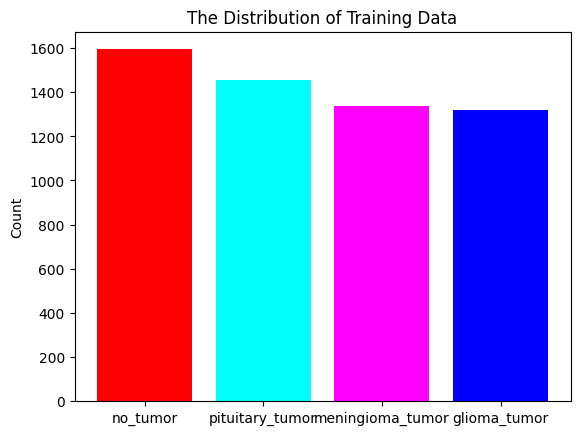

In [11]:
plt.bar(['no_tumor','pituitary_tumor','meningioma_tumor','glioma_tumor'],
        pd.Series(y_train).value_counts(),color=['red','cyan','magenta','blue'])

plt.title('The Distribution of Training Data')
plt.ylabel('Count')
plt.show()

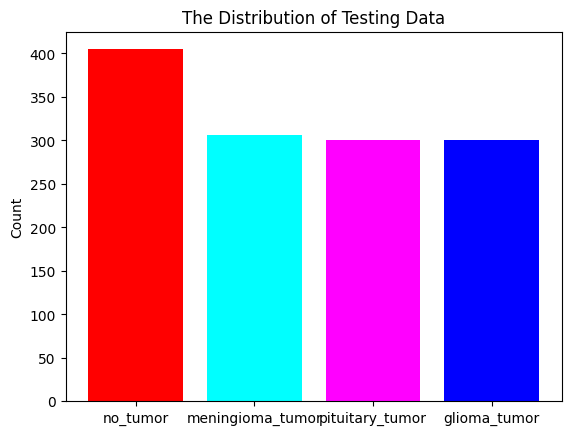

In [12]:
plt.bar(['no_tumor','meningioma_tumor','pituitary_tumor','glioma_tumor']
         ,pd.Series(y_test).value_counts(),color=['red','cyan','magenta','blue'])
plt.title('The Distribution of Testing Data')
plt.ylabel('Count')
plt.show()

In [13]:
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5,random_state=0)

In [14]:
print(len(X_train))
print(len(X_test))
print(len(X_val))
print(len(y_train))
print(len(y_test))
print(len(y_val))

5712
655
656
5712
655
656


In [15]:
X_train=np.array(X_train)
X_test=np.array(X_test)
X_val=np.array(X_val)
y_train=np.array(y_train)
y_test=np.array(y_test)
y_val=np.array(y_val)

In [16]:
y_train=tf.keras.utils.to_categorical(y_train,num_classes=NUM_CLASSES)
y_test=tf.keras.utils.to_categorical(y_test,num_classes=NUM_CLASSES)
y_val=tf.keras.utils.to_categorical(y_val,num_classes=NUM_CLASSES)

In [17]:
print('The shape of X_train',X_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of X_val',X_val.shape)
print('The shape of y_train',y_train.shape)
print('The shape of y_test',y_test.shape)
print('The shape of y_val',y_val.shape)

The shape of X_train (5712, 224, 224, 3)
The shape of X_test (655, 224, 224, 3)
The shape of X_val (656, 224, 224, 3)
The shape of y_train (5712, 4)
The shape of y_test (655, 4)
The shape of y_val (656, 4)


# ***Data Augmentation***

In [18]:
train_datagen = ImageDataGenerator(rescale=RESCALE,rotation_range=ROTATION_RANGE,
            shear_range=SHEAR_RANGE,zoom_range=ZOOM_RANGE,horizontal_flip=HORIZONTAL_FLIP)

val_datagen=ImageDataGenerator(rescale=RESCALE)

test_datagen = ImageDataGenerator(rescale=RESCALE)

In [19]:
train_gen=train_datagen.flow(X_train,y_train,batch_size=BATCH_SIZE)
val_gen=val_datagen.flow(X_val,y_val,batch_size=BATCH_SIZE)
test_gen=test_datagen.flow(X_test,y_test,batch_size=BATCH_SIZE)

# ***Build Model***

In [22]:
cnn=keras.models.Sequential(
[
    keras.layers.Conv2D(32,(FILTER_SIZE,FILTER_SIZE),activation='relu',input_shape=(SIZE,SIZE,CHANNEL)),
    keras.layers.MaxPooling2D(MAXPOOLING_SIZE,MAXPOOLING_SIZE),
    
    keras.layers.Conv2D(64,(FILTER_SIZE,FILTER_SIZE),activation='relu'),
    keras.layers.MaxPooling2D(MAXPOOLING_SIZE,MAXPOOLING_SIZE),
    
    keras.layers.Conv2D(128,(FILTER_SIZE,FILTER_SIZE),activation='relu'),
    keras.layers.MaxPooling2D(MAXPOOLING_SIZE,MAXPOOLING_SIZE),
    
    keras.layers.Conv2D(256,(FILTER_SIZE,FILTER_SIZE),activation='relu'),
    keras.layers.MaxPooling2D(MAXPOOLING_SIZE,MAXPOOLING_SIZE),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.1),
    #output layer
    keras.layers.Dense(4,activation='softmax')
]
)

In [25]:
cnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2, 
                                                 patience=5, 
                                                 min_lr=1e-7, 
                                                 mode='min')

ealystopping=tf.keras.callbacks.EarlyStopping(patience=10,
                                            monitor='val_accuracy',
                                            restore_best_weights=True)

In [27]:
history=cnn.fit(train_gen,epochs=50,validation_data=val_gen
                ,verbose=1,
                callbacks=[ealystopping,reduce_lr])

Epoch 1/50


I0000 00:00:1729845299.002576     113 service.cc:145] XLA service 0x7b6f20003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729845299.002643     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/179 ━━━━━━━━━━━━━━━━━━━━ 36:17 12s/step - accuracy: 0.3125 - loss: 1.3834

I0000 00:00:1729845306.408473     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 346ms/step - accuracy: 0.5101 - loss: 1.0630 - val_accuracy: 0.7241 - val_loss: 0.7102 - learning_rate: 1.0000e-04
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 295ms/step - accuracy: 0.7759 - loss: 0.6021 - val_accuracy: 0.7287 - val_loss: 0.6836 - learning_rate: 1.0000e-04
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 297ms/step - accuracy: 0.8076 - loss: 0.4983 - val_accuracy: 0.7729 - val_loss: 0.5475 - learning_rate: 1.0000e-04
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 56s 299ms/step - accuracy: 0.8528 - loss: 0.3893 - val_accuracy: 0.8186 - val_loss: 0.4169 - learning_rate: 1.0000e-04
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 297ms/step - accuracy: 0.8678 - loss: 0.3630 - val_accuracy: 0.8323 - val_loss: 0.4076 - learning_rate: 1.0000e-04
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 297ms/step - accuracy: 0.8742 - loss: 0.3408 - val_accuracy: 0.8735 - val_loss: 0.3315 - learning_rate: 1.0000e-04
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 294ms/step - 

In [29]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,186,958 (221.97 MB)

 Trainable params: 19,395,652 (73.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,791,306 (147.98 MB)

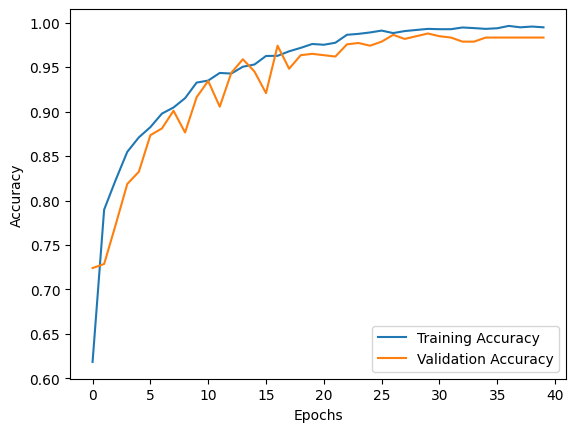

In [30]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

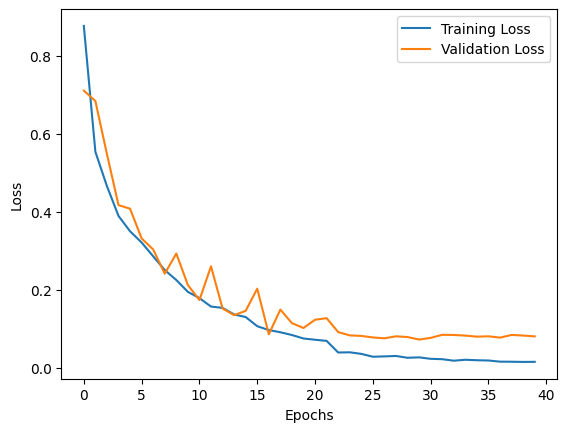

In [31]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
cnn_loss,cnn_accuracy=cnn.evaluate(test_gen)
print(f'Loss is {cnn_loss}')
print(f'Accuracy is {cnn_accuracy}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9924 - loss: 0.0232
Loss is 0.03286859020590782
Accuracy is 0.989313006401062


In [34]:
all_images=np.concatenate([test_gen[i][0] for i in range(len(test_gen))])

In [35]:
y_pred=cnn.predict(all_images)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [36]:
y_pred=np.argmax(y_pred,axis=1)
y_pred[:5]

array([1, 1, 0, 0, 1])

In [37]:
all_labels = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])
print(all_labels[:5])

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
all_labels=np.argmax(all_labels,axis=1)

In [40]:
all_labels[:5]

array([1, 1, 0, 0, 1])

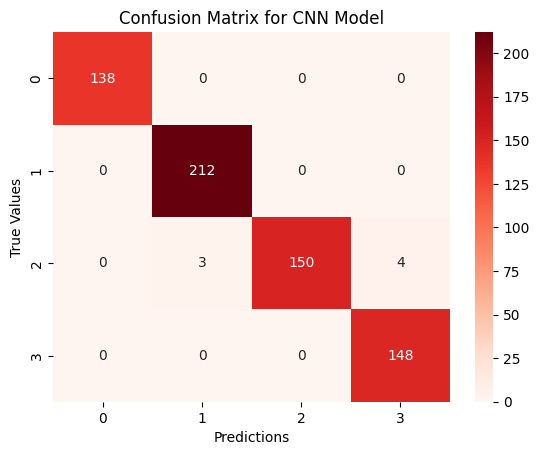

In [41]:
cm=confusion_matrix(all_labels,y_pred)
sns.heatmap(cm,fmt='d',cmap='Reds',annot=True)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Confusion Matrix for CNN Model')
plt.show()

In [42]:
ClassificationReport = classification_report(all_labels,y_pred)
print('Classification Report for CNN Model is : \n', ClassificationReport)

Classification Report for CNN Model is : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       138
           1       0.99      1.00      0.99       212
           2       1.00      0.96      0.98       157
           3       0.97      1.00      0.99       148

    accuracy                           0.99       655
   macro avg       0.99      0.99      0.99       655
weighted avg       0.99      0.99      0.99       655



In [43]:
AccScoreCNNModel = accuracy_score(all_labels, y_pred)
print('Accuracy Score For CNN Model is : ', AccScoreCNNModel)

Accuracy Score For CNN Model is :  0.9893129770992366


# ***Save Model***

In [45]:
cnn.save('cnn_model.h5')

# ***Load Model***

In [2]:
loaded_model = keras.models.load_model('/kaggle/input/save-model/cnn_model (1).h5')

# ***Deployment***

In [3]:
# Preprocess the image for the model
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))  # Resize to the model's input shape
    image = np.array(image) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

In [4]:
def predict(image_path):
    processed_image = preprocess_image(image_path)
    
    # Make prediction
    predictions = loaded_model.predict(processed_image)
    
    class_id = np.argmax(predictions[0])  # Get the class with the highest probability
    
    if class_id == 0:
        return "This image indicates a pituitary tumor, evident by the abnormal mass in the pituitary gland region."
    
    elif class_id == 1: 
        return "This image shows the pituitary gland, confirmed to be free of tumors."
    
    elif class_id == 2:
        return "This image indicates a meningioma, evident by the abnormal growth adjacent to the brain."
    
    else:
        return "This image indicates a glioma tumor, evident by the abnormal growth patterns in the brain."
    

In [45]:
def speak_text(text):
    tts = gTTS(text=text, lang='en')
    tts.save("response.mp3")
    display(Audio("response.mp3", autoplay=True))  # Display and autoplay in the notebook
    
def main(img_path):
    result = predict(img_path)
    print(result)  # Print result to console
    speech=speak_text(result)  # Convert text to speech

In [47]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0003.jpg'

main(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image shows the pituitary gland, confirmed to be free of tumors.


In [5]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0017.jpg'

label=predict(image_path)

I0000 00:00:1729935628.565510      97 service.cc:145] XLA service 0x7ef52c004c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729935628.565562      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1729935629.963658      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
print(f'Predicted class label: {label}')

Predicted class label: This image indicates a glioma tumor, evident by the abnormal growth patterns in the brain.
